# Convert Data to Midi
Data parameters -> Musical Parameters
(X, Y) -> (pitch, intensity)

Tutorial References:

https://medium.com/@astromattrusso/sonification-101-how-to-convert-data-into-music-with-python-71a6dd67751c

https://github.com/SYSTEMSounds/sonification-tutorials/blob/main/data2midi-part1.ipynb

# A. Basics

### 1. Modules & Variables

#### Import basic modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 2. Methods

#### data_overview

In [2]:
# Overview by plotting dataframe by column values

def data_overview(dataframe):
    indices = dataframe.index.values
    for col in (dataframe.columns):

        max_value = max(dataframe[col])
        min_value = min(dataframe[col])
        print('column:', col, ':|:', 'max:', max_value, 'min:', min_value)

        values = dataframe[col].values
        plt.scatter(indices, values, s=1)
        plt.xlabel('index')
        plt.ylabel(col)
        plt.show()

#### map_value

In [3]:
# Maps value (or array of values) from one range to another

def map_value(value, min_input, max_input, min_output, max_output):
    result = min_output + (value - min_input)/(max_input - min_input)*(max_output - min_output)
    return result

#### values_overview

In [4]:
# Overview of single colum dataset by frame index

def values_overview(frame_index, values, lable: str):
    plt.scatter(frame_index, values, s=1)
    plt.xlabel('frame index')
    plt.ylabel(lable)
    plt.show()

### 3. Setup dataframe (.csv file)

Import

In [5]:
SOURCE_PATH = './Brush-positions.csv'
    # file path of input data

df = pd.read_csv(SOURCE_PATH)
df.head()

,x,y,z
0,-0.549436,0.001,-0.487388
1,-0.549571,0.001,-0.487099
2,-0.549945,0.001,-0.486143
3,-0.550511,0.001,-0.484386
4,-0.551219,0.001,-0.481694


Data Overview

... just to look at the overall patterns and structures in the data.

495 records
3 columns 

column: x :|: max: 0.378537 min: -0.572957


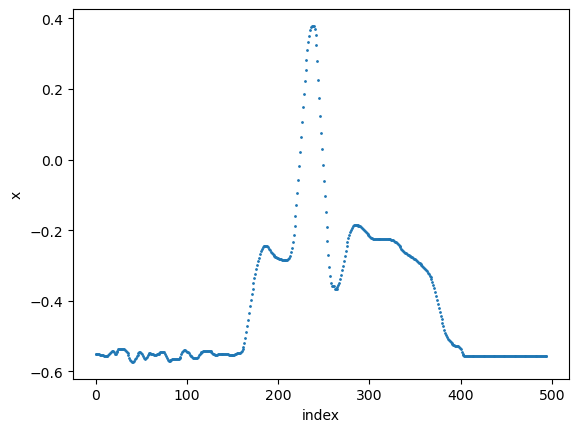

column: y :|: max: 0.006 min: 0.001


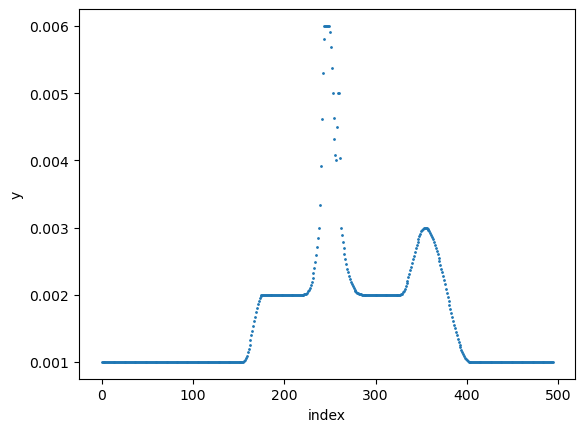

column: z :|: max: 0.275858 min: -0.527612


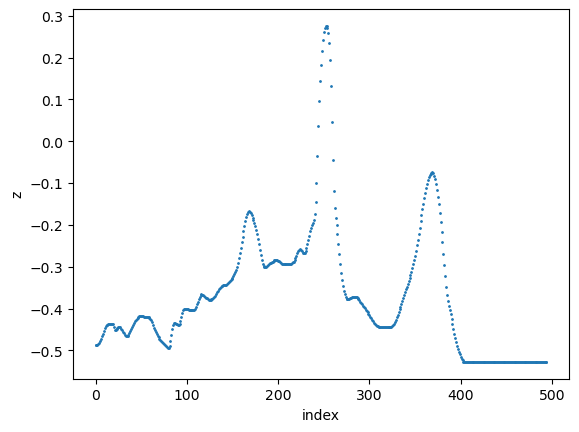

In [6]:
index_length = len(df)
column_length = len(df.columns)
print(index_length, 'records')
print(column_length, 'columns', '\n')

data_overview(df)

# B. Data Modification

## 1. Import basic data

In [7]:
x_positions = df['x'].values
y_positions = df['y'].values
z_positions = df['z'].values
frame_index = df.index.values

## 2. Transform into audio-mutable data

### Tempo (Compression Time) : Timing
how much do you want it to be compressed by in a particular way

- the MIDI file we create will measure time in beats (quarter notes), not in seconds

NOTE:

- I'm using different way than the one with the method that the instructor used. 
- Because I'm not arranging each records into variable time duration, I'm synchronizing each records corresponding to video footage. 
- So the tempo of the sounds depends on the footage FPS and time duration

In [8]:
TARGET_FPS = 15 #(fps)
FRAME_PER_BEAT = 4

original_fps = 30
retime_scale = TARGET_FPS / original_fps
time_duration = index_length / TARGET_FPS
fpm = TARGET_FPS * 60
bpm = (fpm / FRAME_PER_BEAT)
res_timing = frame_index / FRAME_PER_BEAT
duration = max(res_timing)

print('total frames :', index_length, 'frames')
print('target fps :', TARGET_FPS, 'fps')
print('retime_scale :', retime_scale, 'x')
print('frame per bit :', FRAME_PER_BEAT)
print('bpm :', bpm, 'bpm')
print('duration :', duration, 'beats')
print('time duration :', time_duration, 's')

res_timing
# represents each note's chronological position. 
# 0 represents 'at beat 0', 10.75 represents 'at beat 10.75'

total frames : 495 frames
target fps : 15 fps
retime_scale : 0.5 x
frame per bit : 4
bpm : 225.0 bpm
duration : 123.5 beats
time duration : 33.0 s


array([  0.  ,   0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,
         2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,
         4.  ,   4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,
         6.  ,   6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,
         8.  ,   8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,
        10.  ,  10.25,  10.5 ,  10.75,  11.  ,  11.25,  11.5 ,  11.75,
        12.  ,  12.25,  12.5 ,  12.75,  13.  ,  13.25,  13.5 ,  13.75,
        14.  ,  14.25,  14.5 ,  14.75,  15.  ,  15.25,  15.5 ,  15.75,
        16.  ,  16.25,  16.5 ,  16.75,  17.  ,  17.25,  17.5 ,  17.75,
        18.  ,  18.25,  18.5 ,  18.75,  19.  ,  19.25,  19.5 ,  19.75,
        20.  ,  20.25,  20.5 ,  20.75,  21.  ,  21.25,  21.5 ,  21.75,
        22.  ,  22.25,  22.5 ,  22.75,  23.  ,  23.25,  23.5 ,  23.75,
        24.  ,  24.25,  24.5 ,  24.75,  25.  ,  25.25,  25.5 ,  25.75,
        26.  ,  26.25,  26.5 ,  26.75,  27.  ,  27.25,  27.5 ,  27.75,
      

### Velocity (Volume || Strength)
- midi velocity (integer from 0-127) is a combination of volume and intensity (hitting a piano key with a larger velocity makes a louder, more intense sound)

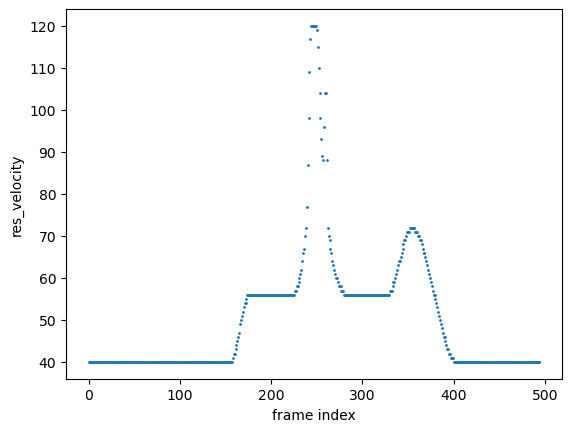

In [9]:
VELOCITY_MIN = 40
VELOCITY_MAX = 120
DATA_FOR_VELOCITY = y_positions
res_velocity = []

velocity_mapped = map_value(DATA_FOR_VELOCITY, min(DATA_FOR_VELOCITY), max(DATA_FOR_VELOCITY), 0, 1)
# y_scale = 0.8
# velocity_mapped = velocity_mapped**y_scale
    # lower than 1 to spread out more evenly

for i in range(len(frame_index)):
    velocity_value_mapped = map_value(velocity_mapped[i], min(velocity_mapped), max(velocity_mapped), VELOCITY_MIN, VELOCITY_MAX)
    velocity_value_rounded = round(velocity_value_mapped)
    res_velocity.append(velocity_value_rounded)

values_overview(frame_index, res_velocity, 'res_velocity')

### Pitch (Convert to midi numbers)

#### Note Sets

In [10]:
# 4 octaves of major scale
notes_major = ['C2','D2','E2','F2','G2','A2','B2',
             'C3','D3','E3','F3','G3','A3','B3',
             'C4','D4','E4','F4','G4','A4','B4',
             'C5','D5','E5','F5','G5','A5','B5']

#4 octaves of major pentatonic scale 
notes_pentatonic = ['C2','D2','E2','G2','A2',
             'C3','D3','E3','G3','A3',
             'C4','D4','E4','G4','A4',
             'C5','D5','E5','G5','A5']

#custom note set (a voicing of a Cmaj13#11 chord, notes from C lydian)
notes_c_lydian = ['C1','C2','G2',
             'C3','E3','G3','A3','B3',
             'D4','E4','G4','A4','B4',
             'D5','E5','G5','A5','B5',
             'D6','E6','F#6','G6','A6']

NOTE :
- for `audiolazy` package, it is recommended to use lower versions below Python 3.10

In [11]:
SELECT_NOTE_SET = notes_pentatonic

from audiolazy import *

# select an notes sets & make a list of midi note numbers 
notes_selected = [str2midi(n) for n in SELECT_NOTE_SET]

notes_selected

[36,
 38,
 40,
 43,
 45,
 48,
 50,
 52,
 55,
 57,
 60,
 62,
 64,
 67,
 69,
 72,
 74,
 76,
 79,
 81]

#### Map data to MIDI note numbers

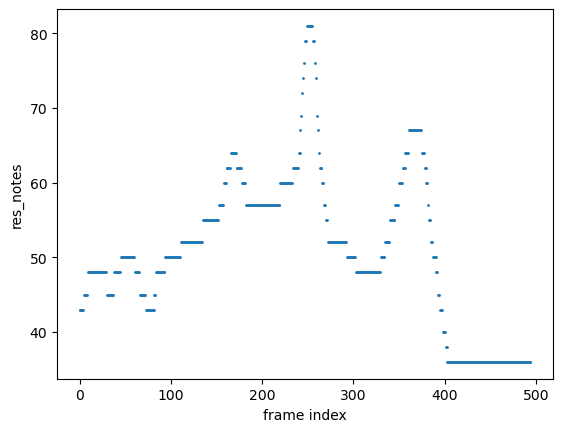

In [12]:
DATA_FOR_PITCH = z_positions
res_notes = []

pitch_mapped = map_value(DATA_FOR_PITCH, min(DATA_FOR_PITCH), max(DATA_FOR_PITCH), 0, 1)
pitch_scale = 0.6
pitch_mapped = pitch_mapped**pitch_scale
    # lower than 1 to spread out more evenly

for i in range(len(frame_index)):
    note_index_mapped = map_value(pitch_mapped[i], min(pitch_mapped), max(pitch_mapped), 0, len(notes_selected)-1)
    note_index_rounded = round(note_index_mapped)
    note_number = notes_selected[note_index_rounded]
    res_notes.append(note_number)

values_overview(frame_index, res_notes, 'res_notes')

## 3. Save data as MIDI file

In [13]:
TRACK_NUM = 1
EACH_DURATION = 1
EXPORT_PATH = './brushPosition2midi-test01.mid'

from midiutil import MIDIFile

# create midi file object
midi_res = MIDIFile(TRACK_NUM)

# add tempo
midi_res.addTempo(track=0, time=0, tempo=bpm)

# add notes
for i in range(len(frame_index)):
    midi_res.addNote(track=0, channel=0, pitch=res_notes[i], time=res_timing[i], duration=EACH_DURATION, volume=res_velocity[i])

# create and save the midi file
with open(EXPORT_PATH, "wb") as f:
    midi_res.writeFile(f)

# C. Testflight within Jupyter

In [14]:
import sys 
# !{sys.executable} -m pip install --quiet "pygame"  #install pygame with pip

#or use this if you installed python with anaconda
!{sys.executable} conda install --yes --prefix {sys.prefix} pygame

import pygame #import library for playing midi files, https://pypi.org/project/pygame/

pygame.init()
pygame.mixer.music.load(EXPORT_PATH)
pygame.mixer.music.play()

c:\Users\Gunn\anaconda3\python.exe: can't open file 'c:\Users\Gunn\Codespace-GitRepo\221120-DataSonification\test-01-brushPositionData01\conda': [Errno 2] No such file or directory


pygame 2.1.2 (SDL 2.0.18, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
